Initializing env 0 with device cpu
Model network size: 6637133
Loaded model net from /home/stephen/RS/thinker/logs/thinker/v14_b_see0x_0.5xsscot/ckp_model.tar


Loaded config from ../logs/thinker/v14_b_see0x_0.5xsscot/config_c.yaml
Loaded config from ../logs/thinker/v14_b_see0x_0.5xsscot/config_c.yaml


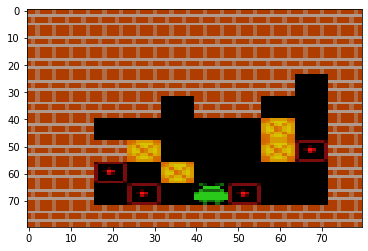

In [56]:
import os
os.chdir(os.path.expanduser('~/RS/thinker/thinker'))

from thinker.util import __version__
from thinker.util import __project__

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.nn import functional as F
from thinker.main import Env
import thinker.util as util
from thinker.self_play import init_env_out, create_env_out
from thinker.actor_net import ActorNet
import gym

xpid = "v14_b_see0x_0.5xsscot"
savedir = "../logs/__project__"

savedir = savedir.replace("__project__", __project__)
ckpdir = os.path.join(savedir, xpid)      
if os.path.islink(ckpdir): ckpdir = os.readlink(ckpdir)  
ckpdir =  os.path.abspath(os.path.expanduser(ckpdir))

max_eps_n = 1
flags = util.create_setting(args=[], savedir=savedir, xpid=xpid, ckp=True)

seed = 1
env = Env(
    name=flags.name,
    env_n=1,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=True,
    return_x=True,
    )

state = env.reset()
env_out = init_env_out(state, flags)
#util.plot_raw_state(state["real_states"][0][:3])
util.plot_raw_state(state["xs"][0][-3:])

num_actions = env.num_actions

obs_space = env.observation_space
action_space = env.action_space  
actor_param = {
            "obs_space":obs_space,
            "action_space":action_space,
            "flags":flags
        }

actor_net = ActorNet(**actor_param)
checkpoint = torch.load(
        os.path.join(flags.ckpdir, "ckp_actor.tar"), torch.device("cpu")
    )
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


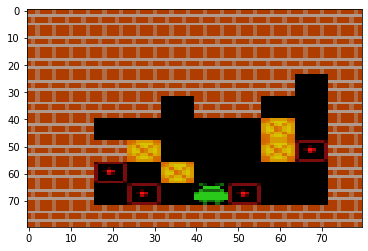

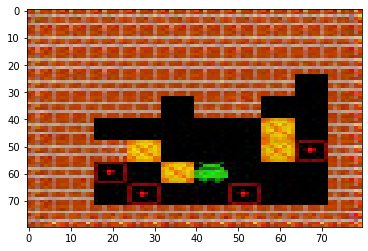

In [13]:
util.plot_raw_state(state["xs"][0][-3:])
actor_out, actor_state = actor_net(
                    env_out, actor_state, greedy=False
                )
action = actor_out.action
state, reward, done, info = env.step(action)
env_out = create_env_out(action, state, reward, done, info, flags)
util.plot_raw_state(state["xs"][0][-3:])

In [57]:
step_statuses, xss_probs, probs, xss_bs, bs = [], [], [], [], []
for _ in range(20):
    actor_out, actor_state = actor_net(
                        env_out, actor_state, greedy=False
                    )
    action = actor_out.action
    state, reward, done, info = env.step(action)
    env_out = create_env_out(action, state, reward, done, info, flags)

    xss_prob, prob = actor_out.misc['debug_xss']['pri_logits']
    xss_probs.append(F.softmax(xss_prob, dim=-1).cpu().numpy()[0,0])
    probs.append(F.softmax(prob, dim=-1).cpu().numpy()[0,0])
    xss_b, b = actor_out.misc['debug_xss']['baselines']
    xss_bs.append(xss_b.cpu().numpy()[0])
    bs.append(b.cpu().numpy()[0])
    step_statuses.append(env_out.step_status[0,0])

xss_probs = np.array(xss_probs)
probs = np.array(probs)    
xss_bs = np.array(xss_bs)
bs = np.array(bs)

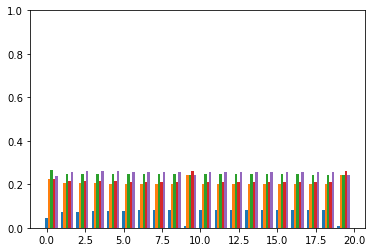

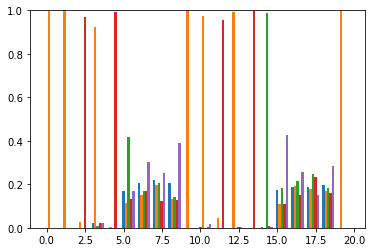

In [58]:
def plot_hist(ys, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
    T, N = ys.shape
    xs = np.arange(T)
    for i in range(N):
        ax.bar(
            xs + 0.8 * (i / N),
            ys[:, i],
            width=0.8 / (N),
        )
    if ylim is not None:
        ax.set_ylim(*ylim)
plot_hist(xss_probs, ylim=(0,1))
plot_hist(probs, ylim=(0,1))

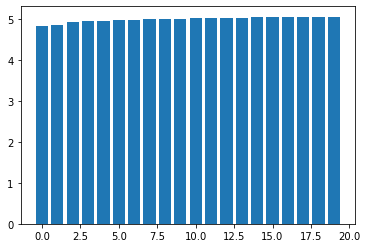

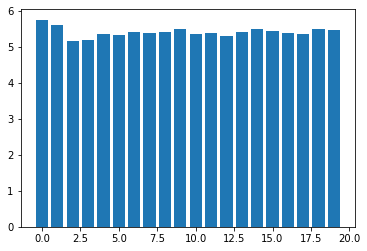

In [59]:
plot_hist(xss_bs)
plot_hist(bs)

In [36]:
print(probs)

[[2.25385720e-05 9.98471081e-01 9.51577567e-06 1.50779277e-04
  1.34608208e-03]
 [5.59944929e-05 9.98235583e-01 6.96498910e-06 1.35273882e-03
  3.48575122e-04]
 [5.28758718e-03 5.07188290e-02 6.29936857e-03 9.35275733e-01
  2.41842237e-03]
 [7.06621930e-02 7.82952309e-01 3.88307981e-02 5.84778897e-02
  4.90768515e-02]
 [7.49169732e-04 7.15618860e-03 1.02986523e-03 9.90793049e-01
  2.71642377e-04]
 [1.76316276e-01 1.27685040e-01 3.80341649e-01 1.42502591e-01
  1.73154444e-01]
 [2.13886514e-01 1.52906910e-01 1.72565222e-01 1.72685876e-01
  2.87955463e-01]
 [2.32547432e-01 1.91751614e-01 2.10771367e-01 1.31459132e-01
  2.33470470e-01]
 [2.09286302e-01 2.16277286e-01 2.40714341e-01 1.11220196e-01
  2.22501874e-01]
 [1.66927148e-05 9.99416232e-01 6.02259315e-05 1.26210623e-04
  3.80630721e-04]
 [2.48010573e-03 9.75835502e-01 5.69913769e-04 6.20956998e-03
  1.49047943e-02]
 [5.20217989e-04 4.67434861e-02 1.05822633e-03 9.51170743e-01
  5.07307705e-04]
 [7.72340689e-04 9.92271781e-01 2.721733

In [37]:
info['sampled_action'] = torch.tensor([[0, 4, 4, 3], [4, 4, 4, 4]], dtype=torch.long)
action = torch.tensor([1, 2], dtype=torch.long)
action_prob = torch.tensor([[0.1, 0.2, 0.4, 0.3], [0.5, 0.1, 0, 0.4]], dtype=torch.float)
action, action_prob = env.to_raw_action(info["sampled_action"], action, action_prob)
print(action, action_prob)

tensor([4, 4]) tensor([[0.1000, 0.0000, 0.0000, 0.3000, 0.6000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])


reward tensor([-0.0100])
tree_reps
root_action tensor([[0., 0., 0., 1., 0.]])
root_r tensor([[-0.2118]])
root_v tensor([[-0.0248]])
root_logits tensor([[-0.0008,  0.0269,  0.0043,  0.0000,  0.0000]])
root_qs_mean tensor([[0., 0., 0., 0., 0.]])
root_qs_max tensor([[0., 0., 0., 0., 0.]])
root_ns tensor([[ 0.0000, -0.2118, -0.2118,  1.0000,  0.0000]])
root_trail_r tensor([[0.]])
root_trail_q tensor([[0.]])
root_max_v tensor([[0.]])
cur_action tensor([[0., 0., 0., 0., 1.]])
cur_r tensor([[0.]])
cur_v tensor([[0.]])
cur_logits tensor([[1., 0., 0., 0., 0.]])
cur_qs_mean tensor([[0., 1., 0., 0., 0.]])
cur_qs_max tensor([[ 0.0000,  1.0000,  0.0000, -0.2118, -0.0248]])
cur_ns tensor([[-0.0008,  0.0269,  0.0043,  0.0000,  0.0000]])
reset tensor([0.])
time tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.]])
derec tensor([[1.]])
raw tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
 

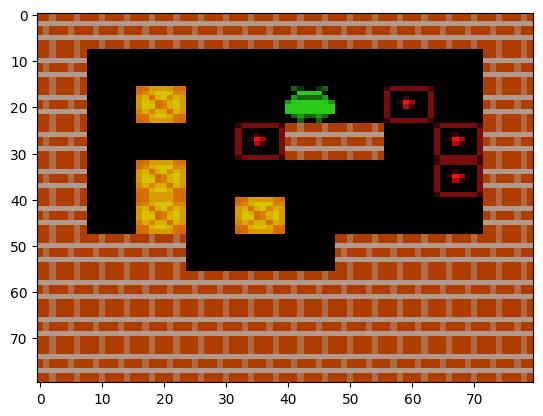

In [11]:
state, reward, done, info = env.step((np.array([1]), np.array([1])))
util.plot_raw_state(state["xs"][0][-3:])
print('reward', reward)
print('tree_reps')
d = util.decode_tree_reps(state['tree_reps'], num_actions=env.num_actions, enc_type=env.flags.model_enc_type)
for k, v in d.items():
    print(k, v)
print("step_status ", info["step_status"])


In [ ]:
import numpy as np
from thinker import self_play
env = self_play.env
env_n = self_play.env_n
actor_net = self_play.actor_net
env.reset()
action = (torch.zeros(env_n, dtype=int), torch.zeros(env_n, dtype=int))
state, reward, done, info = env.step(action)
env_out = self_play.create_env_out(action, state, reward, done, info)
actor_state = actor_net.initial_state(batch_size=env_n, device=self_play.device)
actor_out, actor_state = actor_net(env_out, actor_state)
state, reward, done, info = env.step(actor_out.action)

In [ ]:
import gym_csokoban
from thinker.wrapper import PreWrapper, PostWrapper
from thinker.model_net import ModelNet
from thinker.cenv import cModelWrapper
from thinker.gym_add import AsyncVectorEnv

env_n = 2
device = torch.device("cuda")
frame_stack_n = 1
name = "cSokoban-v0"
#name = "BreakoutNoFrameskip-v4"

env_fn = lambda: PreWrapper(gym.make(name),  name=name,)
env = AsyncVectorEnv([env_fn for _ in range(env_n)])        

raw_state_shape = env.observation_space.shape[1:]
num_actions = env.action_space[0].n
model_net = ModelNet(raw_state_shape, num_actions, flags, frame_stack_n)
model_net.train(False)
model_net.to(device)

wrapper = cModelWrapper
#wrapper = cPerfectWrapper
#wrapper = DummyWrapper
env = wrapper(env, env_n, flags, model_net, device=device, time=False)
env = PostWrapper(env, reward_clip=flags.reward_clip)

env.seed([i for i in range(1, env_n+1)])

state = env.reset(model_net)

real_actions =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 3,] * 10
im_actions =    [1, 2, 3, 0, 0, 2, 2, 3, 3, 0,] * 10
reset_actions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,] * 10

for n, (real, im, reset) in enumerate(zip(real_actions, im_actions, reset_actions)):
    action = np.array([[real, im, reset] for _ in range(env_n)], dtype=np.int32)
    state, reward, done, info = env.step(action, model_net)       
    #cur_t = info["cur_t"][0].item()    
    #print(cur_t)
    #print("state ", state)
    #print("reward ", reward)
    #print("done ", done)
    print("info ", info)